## Web Scraping Project

### ประเด็นปัญหา
บริษัทขาดข้อมูลเพียงพอในการตัดสินใจว่า ควรสต็อกหนังสือประเภทใดที่จะสร้างรายได้สูงสุด การขาดข้อมูลเชิงลึกเกี่ยวกับแนวโน้มราคาหนังสือ ความชอบของลูกค้า และข้อเสนอจากคู่แข่ง ทำให้ไม่สามารถวางแผนกลยุทธ์ได้อย่างแม่นยำ การวิเคราะห์ข้อมูลจากแหล่งข้อมูลออนไลน์จึงเป็นวิธีที่มีประสิทธิภาพในการช่วยเหลือบริษัทในการตัดสินใจ

### วัตถุประสงค์
ร้านขายหนังสือออนไลน์สตาร์ทอัพต้องการปรับกลยุทธ์การเลือกสต็อกหนังสือให้มีความสอดคล้องกับแนวโน้มของตลาดในปัจจุบัน เป้าหมายหลักของการวิเคราะห์ข้อมูลครั้งนี้คือการช่วยให้บริษัทตัดสินใจเกี่ยวกับการเลือกหนังสือสต็อกที่สามารถเพิ่มผลตอบแทนจากการลงทุน เบื้องต้นได้อย่างมีประสิทธิภาพ การทำเช่นนี้จะช่วยให้ธุรกิจเติบโตในตลาดที่มีการแข่งขันสูง

### ความสำคัญของการวิเคราะห์ข้อมูล
ข้อมูลจากการจัดอันดับหนังสือ บทวิจารณ์ แนวโน้มราคา และรูปแบบการสต็อกหนังสือ เป็นปัจจัยสำคัญที่สามารถให้ข้อมูลเชิงลึกเกี่ยวกับความต้องการของตลาด การวิเคราะห์ข้อมูลเหล่านี้จะช่วยให้ร้านสามารถเข้าใจแนวโน้มและความชอบของลูกค้าได้ดีขึ้น รวมถึงการใช้ข้อมูลดังกล่าวในการตัดสินใจเรื่องราคาหนังสือ การจัดการสต็อก และการวางกลยุทธ์การขายในระยะยาวได้

ขั้นตอนที่ 1 การดึงข้อมูลจากเว็บ (Web Scraping) 

In [ ]:
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
from urllib.parse import urljoin  # Import the urljoin function

Extracted_links = []

for i in range(49):
    # Correct the base URL to the root of the book listings
    base_url = f'https://books.toscrape.com/catalogue/category/books_1/page-{i + 1}.html'

    # Open connection and grab the main page
    uClient = uReq(base_url)
    page_html = uClient.read()
    uClient.close()

    # HTML parsing
    page_soup = soup(page_html, "html.parser")

    # Find the correct link by inspecting where the relative links start
    for bookLink in page_soup.findAll("h3"):
       Extracted_links.append(urljoin(base_url, bookLink.find('a')['href']))

# Print the correctly formed URLs
for link in Extracted_links:
    print(link)


In [ ]:
import csv
import requests
from bs4 import BeautifulSoup as soup

number_mapping = {
"One": 1,
"Two": 2,
"Three": 3,
"Four": 4,
"Five": 5
}   

# Test_links = ["https://books.toscrape.com/catalogue/hawkeye-vol-1-my-life-as-a-weapon-hawkeye-1_24/index.html","https://books.toscrape.com/catalogue/having-the-barbarians-baby-ice-planet-barbarians-75_23/index.html"]

# Create CSV file of all products
filename = "Books_data.csv"
with open(filename, mode="w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    
    # Write header row
    writer.writerow(["Genre", "Book Title", "Price", "Rating", "Stock Status", "Number of Reviews"])

    # Loop through each collected book link to access detail pages
    for link in Extracted_links:
        # Fetch the detail page
        response = requests.get(link)
        detail_html = response.text
        
        # HTML parsing for detail page
        detail_soup = soup(detail_html, "html.parser")

        # Extracting detailed product information
        product_info = {row.th.text: row.td.text for row in detail_soup.findAll("tr")}
        category = detail_soup.find('ul', class_="breadcrumb").find_all('a')[2].text.strip()
        title = detail_soup.find('h1').text
        price = product_info.get("Price (incl. tax)")
        rating = number_mapping.get(detail_soup.find('p', class_="star-rating")['class'][1], "Invalid input")
        stock_status = product_info.get("Availability")
        number_of_reviews = product_info.get("Number of reviews")

        # Write the product details to the CSV
        writer.writerow([category, title, price, rating, stock_status, number_of_reviews])

        print(title, "finished")

ขั้นตอนที่ 2 การทำความสะอาดและเตรียมข้อมูล (Data Cleaning and Preparation)

In [ ]:
import pandas as pd

df = pd.read_csv('Books_data.csv')

print(df.info())   # ตรวจสอบชนิดของข้อมูลในแต่ละคอลัมน์และจำนวนข้อมูลที่ไม่เป็น null
print(df.duplicated().sum())    # ตรวจสอบข้อมูลที่ซ้ำกัน
df['Price'] = df['Price'].str.replace('[Ã‚Â£]', '', regex=True) #ลบสกุลเงินออก
df['Stock Status'] = df['Stock Status'].str.replace(r'\D+', '', regex=True) #ลบstr
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df[(df['Rating'] >= 1) & (df['Rating'] <= 5)]  # ตรวจสอบค่า Rating ที่ไม่อยู่ในช่วงที่เหมาะสม (1-5)
df = df[df['Price'] > 0]    # ตรวจสอบราคาหนังสือที่อาจไม่สมเหตุสมผล
df = df.drop(columns = "Number of Reviews")

duplicate_count = df.duplicated(subset=['Book Title']).sum()
print(duplicate_count)

# ตรวจสอบแถวที่มีชื่อซ้ำ
duplicates = df[df.duplicated(subset=['Book Title'], keep=False)]
# หาและนับชื่อที่ซ้ำ
duplicate_titles = duplicates['Book Title'].value_counts()
print(duplicate_titles)


df.to_csv('cleaned_data.csv', index=False)


ขั้นตอนที่ 3 การวิเคราะห์ข้อมูล (Data Analysis)

In [2]:
import pandas as pd
import scipy.stats as stats
# โหลดข้อมูลที่ cleanแล้ว
df = pd.read_csv('cleaned_data.csv')

In [3]:
#จัดอันดับความนิยมของหนังสือแต่ล่ะประเภทและ หาค่าเฉลี่ยของ price ตามประเภท
genre_mean_price_rating = df.groupby('Genre')[['Rating','Price']].mean()
ranking_genre_byRating = genre_mean_price_rating.sort_values(by='Rating', ascending=False)
ranking_genre_byRating

,Rating,Price
Genre,,
Erotica,5.000000,19.190000
Adult Fiction,5.000000,15.360000
Novels,5.000000,54.810000
Christian Fiction,4.166667,34.385000
Health,3.750000,51.452500
Art,3.625000,38.520000
Poetry,3.526316,35.974211
Humor,3.400000,33.501000
Spirituality,3.333333,35.098333


In [4]:
#การทดสอบ ANOVA สำหรับความแตกต่างของราคาตาม Genre
f_val, p_val = stats.f_oneway(*(df[df['Genre'] == genre]['Price'] for genre in df['Genre'].unique()))
print("F-Value of genre:", f_val)
print("P-Value of genre:", p_val)

#------------------------------------------------------------------------------------------------------

#การทดสอบ ANOVA สำหรับความแตกต่างของราคาตาม rating
df['Rating_Category'] = pd.cut(df['Rating'],
                               bins=[0, 2, 4, 5],  # กำหนดช่วงคะแนน
                               labels=['Low', 'Medium', 'High'])  # ตั้งชื่อกลุ่ม
# สร้างลิสต์ของข้อมูลราคาในแต่ละกลุ่มของ Rating
price_by_rating = [df[df['Rating_Category'] == category]['Price'] for category in df['Rating_Category'].unique()]

# ทำการทดสอบ ANOVA
f_val, p_val = stats.f_oneway(*price_by_rating)

print("F-Value of rating:", f_val)
print("P-Value of rating:", p_val)


F-Value of genre: 0.9946210445528134
P-Value of genre: 0.4855264643252697
F-Value of rating: 0.3894629574907809
P-Value of rating: 0.67752570379754


ขั้นตอนที่ 4 การสร้างภาพแสดงข้อมูล (Visualization)

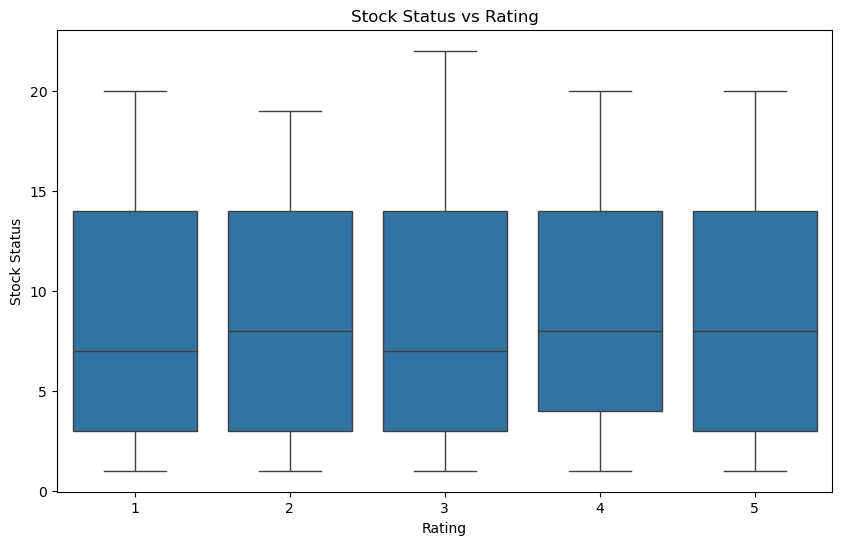

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
# แสดงการกระจายของ Stock Status ตาม Rating
plt.figure(figsize=(10, 6))
sns.boxplot(y='Stock Status', x='Rating', data=df)
plt.title('Stock Status vs Rating')
plt.show()

# การวิเคราะห์ความสัมพันธ์ของ Stock Status กับ Genre
stock_status_genre = df.groupby('Genre')['Stock Status'].mean()

# print("Average Stock Status by Genre:")
# print(stock_status_genre)

Text(0.5, 1.0, 'Visualization')

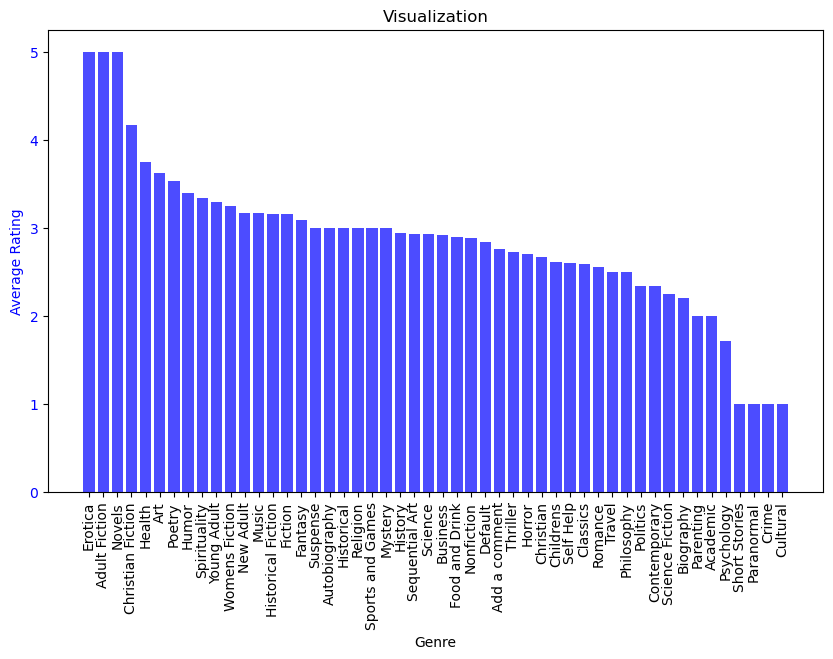

In [6]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(ranking_genre_byRating.index, ranking_genre_byRating['Rating'], color='b', alpha=0.7, label='Rating')
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average Rating', color='b')
ax1.tick_params(axis='y', labelcolor='b')
plt.xticks(rotation=90)
plt.title('Visualization')

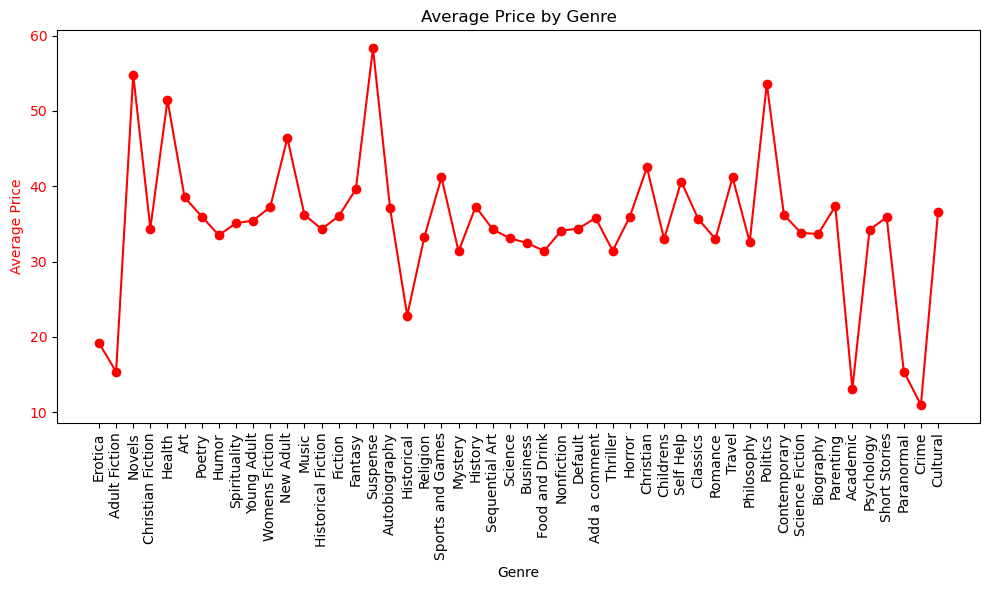

In [7]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(ranking_genre_byRating.index, ranking_genre_byRating['Price'], color='r', marker='o', label='Price')
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average Price', color='r')
ax1.tick_params(axis='y', labelcolor='r')

plt.title('Average Price by Genre')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


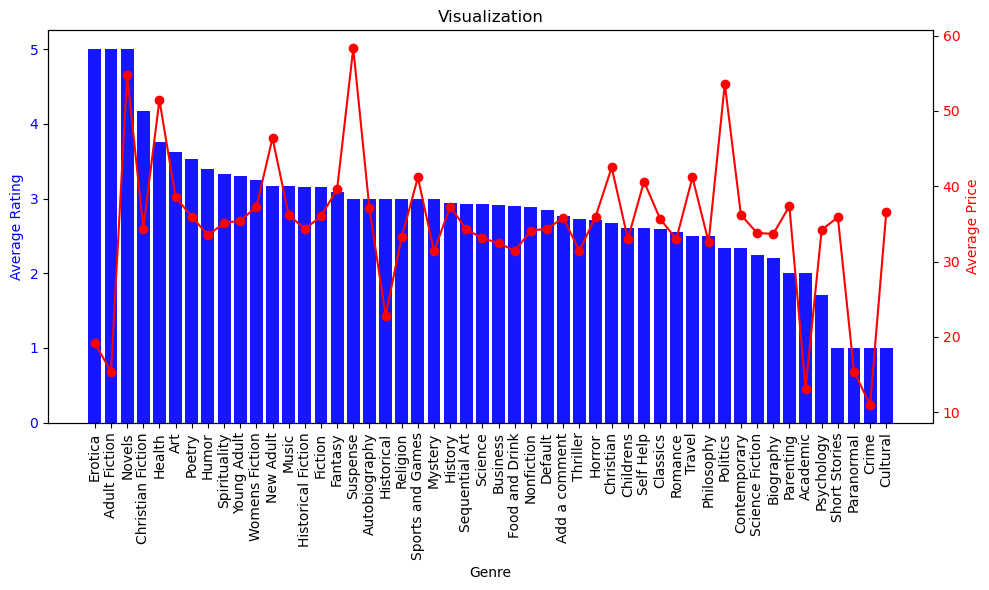

In [8]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(ranking_genre_byRating.index, ranking_genre_byRating['Rating'], color='b', alpha=0.7, label='Rating')
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average Rating', color='b')
ax1.tick_params(axis='y', labelcolor='b')
plt.xticks(rotation=90)
plt.title('Visualization')

ax1.bar(ranking_genre_byRating.index, ranking_genre_byRating['Rating'], color='b', alpha=0.7, label='Rating')
ax1.set_xlabel('Genre')
ax1.set_ylabel('Average Rating', color='b')
ax1.tick_params(axis='y', labelcolor='b')
plt.xticks(rotation=90)
plt.title('Visualization')

ax2 = ax1.twinx()
ax2.plot(ranking_genre_byRating.index, ranking_genre_byRating['Price'], color='r', marker='o', label='Price')
ax2.set_ylabel('Average Price', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.tight_layout()
plt.show()

## รายชื่อสมาชิกในกลุ่ม
| ลำดับ | ชื่อ                      | รหัสนิสิต          |
|--------|-----------------------|------------------|
| 1      | นาย ณัฐดนัย กุลโชติ      | 65109010207      |
| 2      | นาย นนทชา หวลจิตต์     | 65109010208      |
| 3      | นางสาว พิมพ์วิมล พุทธเสน | 65109010300      |
| 4      | นาย ณภัทร นุชิตประสิทธิชัย | 65109010293      |
